In [33]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torchvision
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.datasets import ImageNet, CIFAR10

from pathlib import Path

from tqdm.notebook import tqdm

from einops import einsum, rearrange, reduce

from typing import Union, Tuple, Any, Generator
from torchvision.transforms._presets import ImageClassification


In [29]:
weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [30]:
model = resnet18(weights=weights)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
for layer_i, param in enumerate(model.parameters()):
    print('Layer', layer_i, 'shape: \n', param.shape,  '\n')

Layer 0 shape: 
 torch.Size([64, 3, 7, 7]) 

Layer 1 shape: 
 torch.Size([64]) 

Layer 2 shape: 
 torch.Size([64]) 

Layer 3 shape: 
 torch.Size([64, 64, 3, 3]) 

Layer 4 shape: 
 torch.Size([64]) 

Layer 5 shape: 
 torch.Size([64]) 

Layer 6 shape: 
 torch.Size([64, 64, 3, 3]) 

Layer 7 shape: 
 torch.Size([64]) 

Layer 8 shape: 
 torch.Size([64]) 

Layer 9 shape: 
 torch.Size([64, 64, 3, 3]) 

Layer 10 shape: 
 torch.Size([64]) 

Layer 11 shape: 
 torch.Size([64]) 

Layer 12 shape: 
 torch.Size([64, 64, 3, 3]) 

Layer 13 shape: 
 torch.Size([64]) 

Layer 14 shape: 
 torch.Size([64]) 

Layer 15 shape: 
 torch.Size([128, 64, 3, 3]) 

Layer 16 shape: 
 torch.Size([128]) 

Layer 17 shape: 
 torch.Size([128]) 

Layer 18 shape: 
 torch.Size([128, 128, 3, 3]) 

Layer 19 shape: 
 torch.Size([128]) 

Layer 20 shape: 
 torch.Size([128]) 

Layer 21 shape: 
 torch.Size([128, 64, 1, 1]) 

Layer 22 shape: 
 torch.Size([128]) 

Layer 23 shape: 
 torch.Size([128]) 

Layer 24 shape: 
 torch.Size([128

In [55]:
BATCH_SIZE = 64

try:
    from google.colab import drive
    drive.mount('/content/drive')
    datapath = Path().cwd() / 'drive' / 'MyDrive' / 'data'
except:
    datapath = Path().cwd() / 'data'
finally:
    print(f'Data from {datapath}')
    
cifar10 = CIFAR10(
    root=datapath,
    train=False,
    transform=transforms,
    download=True
)

cifar10_test = CIFAR10(
    root=datapath,
    train=False,
    transform=transforms,
    download=True
)

dataloader = torch.utils.data.DataLoader(
    cifar10,
    batch_size=BATCH_SIZE,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    cifar10_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Data from c:\Users\akiah\OneDrive\Documents\ai231-machine-learning-operations\alexnet-numpy\data


In [53]:
label_mapping = dict(enumerate(cifar10.classes))
label_mapping

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [ ]:
def visualize_normalized_image(image: torch.Tensor, 
                               transform: ImageClassification) -> None:
    """
    Combines a batch of images into 1 and plots them.
    """
    assert isinstance(image, torch.Tensor), f'image type is {type(image)}'
    assert BATCH_SIZE % 2 == 0, f'uneven {BATCH_SIZE}'

    image = image.numpy()
    std, mean = transform.std, transform.mean
    std, mean = np.array(std), np.array(mean)

    b1, b2 = BATCH_SIZE//8, 8
    image = einsum(image, std, 'b c h w, c -> b h w c') + mean
    image = rearrange(image, '(b1 b2) h w c -> (b1 h) (b2 w) c', b1=b1, b2=b2)
    image = np.clip(image, 0, 1)
    
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    print('Shape: ', image.shape)

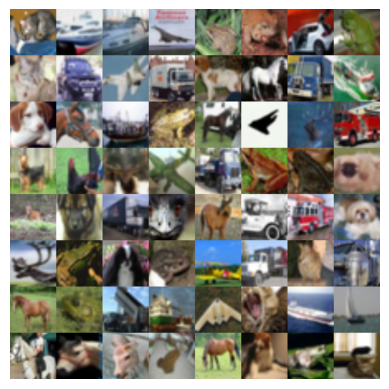

Shape:  (1792, 1792, 3)


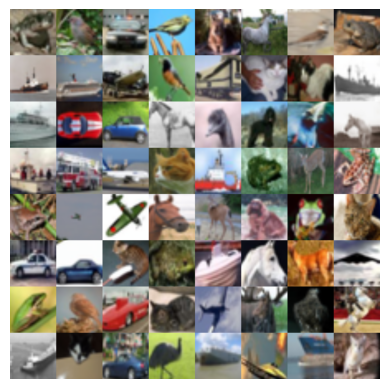

Shape:  (1792, 1792, 3)


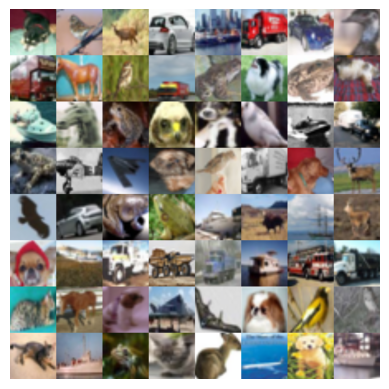

Shape:  (1792, 1792, 3)


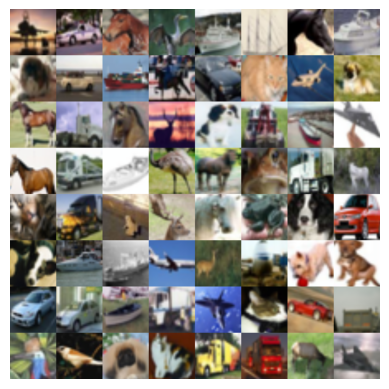

Shape:  (1792, 1792, 3)


In [42]:
n_of_batch_images_to_show = 4
current_label = None

for i, (image, label) in enumerate(dataloader):
    label0 = int(label[0])

    if label0 != current_label:
        # print('Label', label0)
        visualize_normalized_image(image, transforms)
        n_of_batch_images_to_show -= 1
        current_label = label0

    if n_of_batch_images_to_show == 0:
        break


In [ ]:
model.eval()
total_correct = 0
total_samples = 0
i = 0
with torch.no_grad():
    for images, labels in tqdm(dataloader_test):
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        i += 1

    accuracy = total_correct / total_samples


  0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
accuracy

0.80625